# Module Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("../data/data_processed.csv",sep=";")

In [2]:
df.head(10)

,Time,Physical cell identity (pcell),Band (pcell),RSRP (pcell),RSRQ (pcell),RLC downlink throughput,SINR,qos
0,9:39:11.769,224.0,0,-77.0,-5.0,0.0,2.781513,0.0
1,9:39:12.769,224.0,0,-77.0,-5.0,0.0,2.781513,0.0
2,9:39:13.769,224.0,0,-77.0,-5.0,0.0,2.781513,0.0
3,9:39:14.769,224.0,0,-77.0,-7.0,0.0,0.781513,0.0
4,9:39:15.769,224.0,0,-77.0,-6.0,14.7,1.781513,0.5
5,9:39:16.770,224.0,0,-77.0,-6.0,17.9,1.781513,0.5
6,9:39:17.770,224.0,0,-77.0,-6.0,12.2,1.781513,0.5
7,9:39:18.770,224.0,0,-76.0,-5.0,16.2,2.781513,0.5
8,9:39:19.770,224.0,0,-77.0,-6.0,18.5,1.781513,0.5
9,9:39:20.771,224.0,0,-77.0,-5.0,16.5,2.781513,0.5


# Creation of the RL environment using Gymnasium

In [3]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [4]:
import gym
from gymnasium import spaces

In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class NetworkOptimizationEnv(gym.Env):
    def __init__(self, data):
        super(NetworkOptimizationEnv, self).__init__()
        self.data = data
        self.current_index = 0

        # Define the observation space (RSRP, RSRQ, Throughput)
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

        # Define the action space: 0 -> improve RSRP, 1 -> improve RSRQ, 2 -> boost Throughput
        self.action_space = spaces.Discrete(3)

        # Initialize reward history
        self.reward_history = []

        # Set threshold for moving average reward and maximum number of steps
        self.threshold = 0.2  # Threshold for moving average
        self.max_steps = 100  # Maximum steps per episode
        self.step_count = 0  # Step counter

    def step(self, action):
        # Copy current state (do not modify original directly)
        state = self.data[self.current_index].copy()

        # Simulate controlled effects of actions
        if action == 0:  # Action: improve RSRP
            state[0] = min(state[0] + 0.05, 1.0)
            state[1] = max(state[1] - 0.01, 0.0)  # Small compromise on RSRQ
        elif action == 1:  # Action: improve RSRQ
            state[1] = min(state[1] + 0.04, 1.0)
        elif action == 2:  # Action: boost Throughput
            state[2] = min(state[2] + 0.07, 1.0)

        # Calculate weighted reward
        reward = 0.4 * state[0] + 0.3 * state[1] + 0.3 * state[2]

        # Add reward to history
        self.reward_history.append(reward)

        # Compute moving average reward over last 10 steps
        moving_avg_reward = sum(self.reward_history[-10:]) / len(self.reward_history[-10:])

        # Check if episode should terminate
        terminated = moving_avg_reward < self.threshold or (self.step_count >= self.max_steps)
        truncated = False  # No truncation is used here

        # Increment step counter
        self.step_count += 1

        # Move to next index in the dataset
        self.current_index = (self.current_index + 1) % len(self.data)

        return state, reward, terminated, truncated, {}

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_index = 0
        self.step_count = 0  # Reset step counter
        return self.data[self.current_index].copy(), {}


# Training with Monitor, DummyVecEnv, and EvalCallback (best model)

In [7]:
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
# Retrieve and normalize the relevant features directly into states
states = scaler.fit_transform(df[['RSRP (pcell)', 'RSRQ (pcell)', 'RLC downlink throughput']].values) # Retrieve relevant columns

# Split en train et test
train_states, test_states = train_test_split(states, test_size=0.2, random_state=42)


# ======================
# === Environments
# ======================

# Training environment
env = NetworkOptimizationEnv(train_states)
env = Monitor(env, "./logs")
env = DummyVecEnv([lambda: env])

# Validation environment
eval_env = NetworkOptimizationEnv(test_states)
eval_env = Monitor(eval_env)
eval_env = DummyVecEnv([lambda: eval_env])

# ====================
# === Learning
# ====================
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model",
    log_path="./eval_logs",
    eval_freq=5000,
    n_eval_episodes=5,
    deterministic=True,
    render=False,
    verbose=1
)

# Initialize and train DQN model
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000, callback=eval_callback)

# ✅ Save the final model
model.save("network_optimization_rl")


Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | 49.9     |
|    exploration_rate | 0.923    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 465      |
|    time_elapsed     | 0        |
|    total_timesteps  | 404      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.198    |
|    n_updates        | 75       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | 49.9     |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 454      |
|    time_elapsed     | 1        |
|    total_timesteps  | 808      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0716   |
|  

# Reward Visualization During Reinforcement Learning Training

In [8]:
# Check Stable Baselines3 Version
import stable_baselines3

print(stable_baselines3.__version__)


2.6.0


      reward  length      time
0  49.863563   101.0  5.114445
1  49.941563   101.0  5.520291
2  49.893563   101.0  5.737855
3  49.887563   101.0  5.953136
4  49.867563   101.0  6.177511
 Loaded columns: Index(['reward', 'length', 'time'], dtype='object')


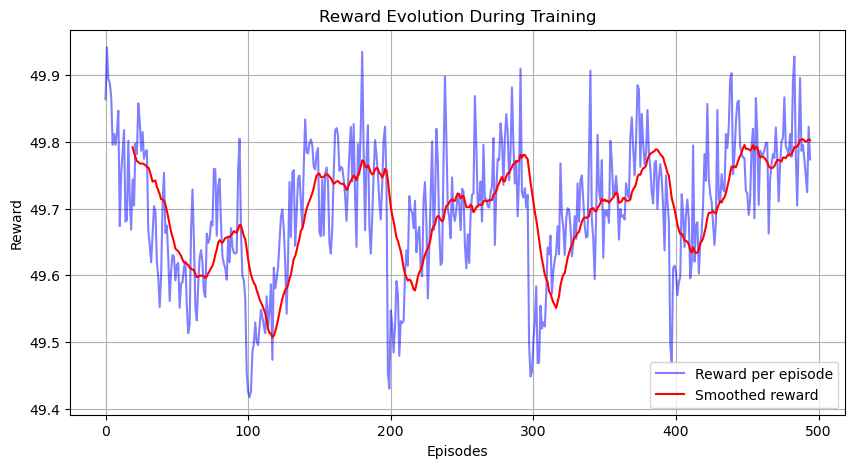

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = './logs.monitor.csv'

try:
    # Read the data, skipping the initial JSON line and header
    df = pd.read_csv(log_path, skiprows=2, names=["reward", "length", "time"])

    # Clean the data (convert to float)
    for col in ["reward", "length", "time"]:
        df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

    print(df.head())
    print(" Loaded columns:", df.columns)

    # Plot the curves
    plt.figure(figsize=(10, 5))
    plt.plot(df["reward"], label="Reward per episode", color='blue', alpha=0.5)

    df["reward_smoothed"] = df["reward"].rolling(window=20).mean()
    plt.plot(df["reward_smoothed"], label="Smoothed reward", color='red')

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Reward Evolution During Training")
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"❌ File not found: {log_path}")
except Exception as e:
    print(f"❌ An error occurred: {e}")


# Training Metrics Visualization with Dual Axes

      reward  length      time
0  49.863563   101.0  5.114445
1  49.941563   101.0  5.520291
2  49.893563   101.0  5.737855
3  49.887563   101.0  5.953136
4  49.867563   101.0  6.177511
Loaded columns: Index(['reward', 'length', 'time'], dtype='object')


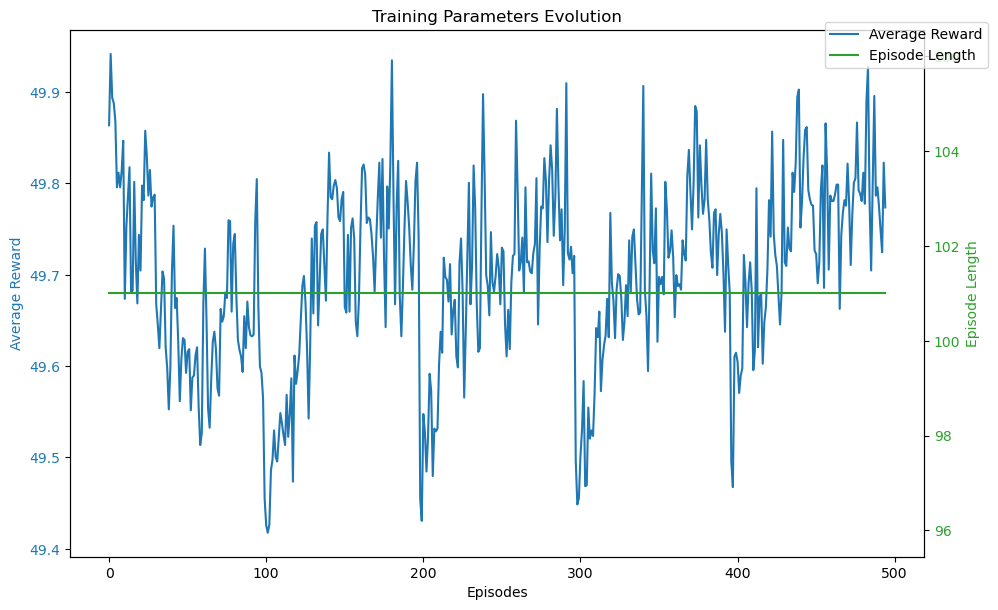

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

log_path = './logs.monitor.csv'

try:
    # Read the data, skipping the initial JSON line and header
    df = pd.read_csv(log_path, skiprows=2, names=["reward", "length", "time"])

    # Clean the data (convert to float)
    for col in ["reward", "length", "time"]:
        df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

    print(df.head())
    print("Loaded columns:", df.columns)

    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the average reward per episode
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Average Reward', color='tab:blue')
    ax1.plot(df.index, df['reward'], color='tab:blue', label="Average Reward")
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for episode length
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Episode Length', color='tab:green')  
    ax2.plot(df.index, df['length'], color='tab:green', label="Episode Length")
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Display the legend
    fig.tight_layout()
    fig.legend(loc="upper right", bbox_to_anchor=(1, 1))
    plt.title("Training Parameters Evolution")

    # Show the plot
    plt.show()

except FileNotFoundError:
    print(f"❌ File not found: {log_path}")
except Exception as e:
    print(f"❌ An error occurred: {e}")


# Evaluate Saved DQN Model

In [11]:
from stable_baselines3 import DQN

# Reload the best model saved during training
best_model = DQN.load("./best_model/best_model")

def evaluate_model(model, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()[0]  # Reset the environment at the start of each episode
        done = False
        total_reward = 0

        while not done:
            # Predict the action from the current observation
            action, _ = model.predict(obs, deterministic=True)
            
            # Take a step in the environment
            obs, reward, terminated, truncated, _ = env.step(action)
            
            # Accumulate the reward
            total_reward += reward
            
            # Check if the episode has finished
            done = terminated or truncated

        # Store the total reward of the episode
        rewards.append(total_reward)
    
    return rewards  # Return the list of rewards for all episodes


# Evaluating the Best DQN Model

In [12]:
from stable_baselines3 import DQN

# Reload the best model saved during training
best_model = DQN.load("./best_model/best_model")

def evaluate_model(model, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()  # env.reset() returns a tuple (obs, infos)
        obs = obs[0]  # Extract the actual observation from the tuple
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)

            # Ensure the action is in a batch-like format (even if there's only one environment)
            if isinstance(action, np.ndarray):
                action = action.reshape(1, -1)  # Reshape action to (1, n_actions)

            # Pass the batch-like action to the environment
            result = env.step(action)
            
            # Unpack only the first four values (if info is not present)
            obs, reward, terminated, truncated = result[:4]  # Ignore the info field if present
            total_reward += reward
            done = terminated or truncated

        rewards.append(total_reward)
    return rewards


# Visualization of Model Performance: Training vs Test Rewards

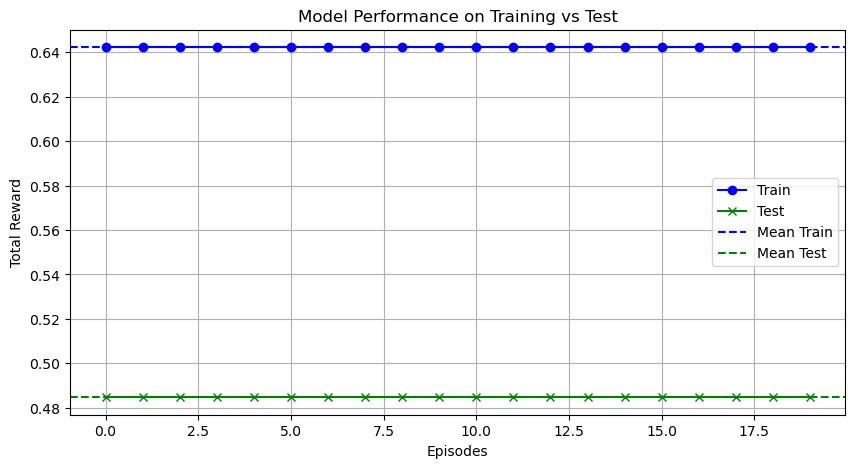

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create simple environments (without Monitor)
env_train_eval = DummyVecEnv([lambda: NetworkOptimizationEnv(train_states)])
env_test_eval = DummyVecEnv([lambda: NetworkOptimizationEnv(test_states)])

# Evaluate on both datasets
train_rewards = evaluate_model(best_model, env_train_eval, n_episodes=20)
test_rewards = evaluate_model(best_model, env_test_eval, n_episodes=20)

# 📉 Plotting
plt.figure(figsize=(10, 5))

# Plot rewards for the training set
plt.plot(train_rewards, label="Train", marker='o', color='blue')

# Plot rewards for the test set
plt.plot(test_rewards, label="Test", marker='x', color='green')

# Add horizontal lines showing the mean reward for both datasets
plt.axhline(np.mean(train_rewards), color='blue', linestyle='--', label='Mean Train')
plt.axhline(np.mean(test_rewards), color='green', linestyle='--', label='Mean Test')

# Set the title and labels for the plot
plt.title("Model Performance on Training vs Test")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")

# Display the legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
